In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score
import kaggle_evaluation.jane_street_inference_server
import os
import gc



import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as L
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer)
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Timer
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import multiprocessing

multiprocessing.cpu_count()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ten/pytorch/default/1/ten.ckpt
/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parqu

4

In [3]:
# Specify the range of files to read
file_names = [f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet" for i in range(5, 6)]

# Use lazy frames to read and combine the data
combined_df = None
for file_name in file_names:
    lazy_frame = pl.scan_parquet(file_name)  # Use scan_parquet for lazy loading
    if combined_df is None:
        combined_df = lazy_frame
    else:
        combined_df = pl.concat([combined_df, lazy_frame])

# Collect into a single DataFrame (trigger computation)
df = combined_df.collect()

test_df = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet")

In [4]:
df.shape

(30302272, 92)

In [6]:
#sns.heatmap(df.to_pandas().corr(), cmap="vlag")

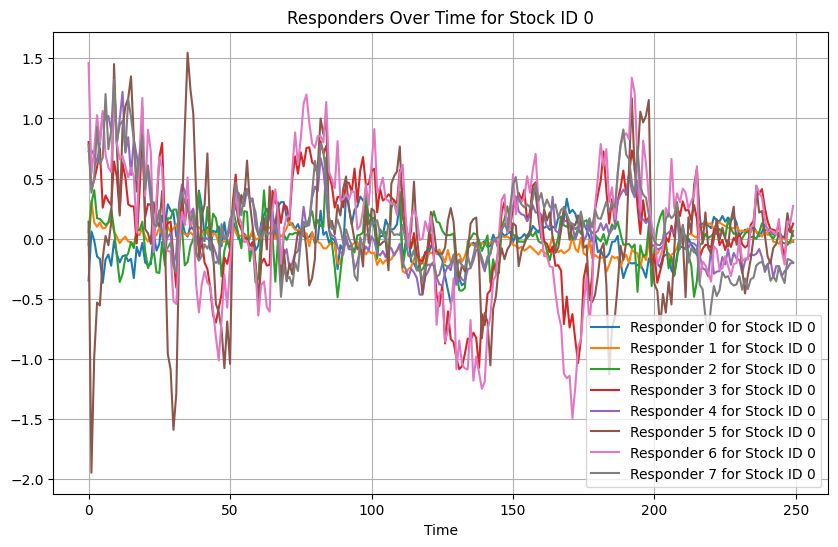

In [7]:
def plot_stock(stock_id):
    stock_data = df.filter(pl.col("symbol_id") == stock_id)
            
    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.plot(stock_data[f"responder_{i}"][:250], label=f"Responder {i} for Stock ID {stock_id}")
    plt.xlabel("Time")
    plt.title(f"Responders Over Time for Stock ID {stock_id}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_stock(0)

Text(0.5, 1.02, 'Feature Distributions')

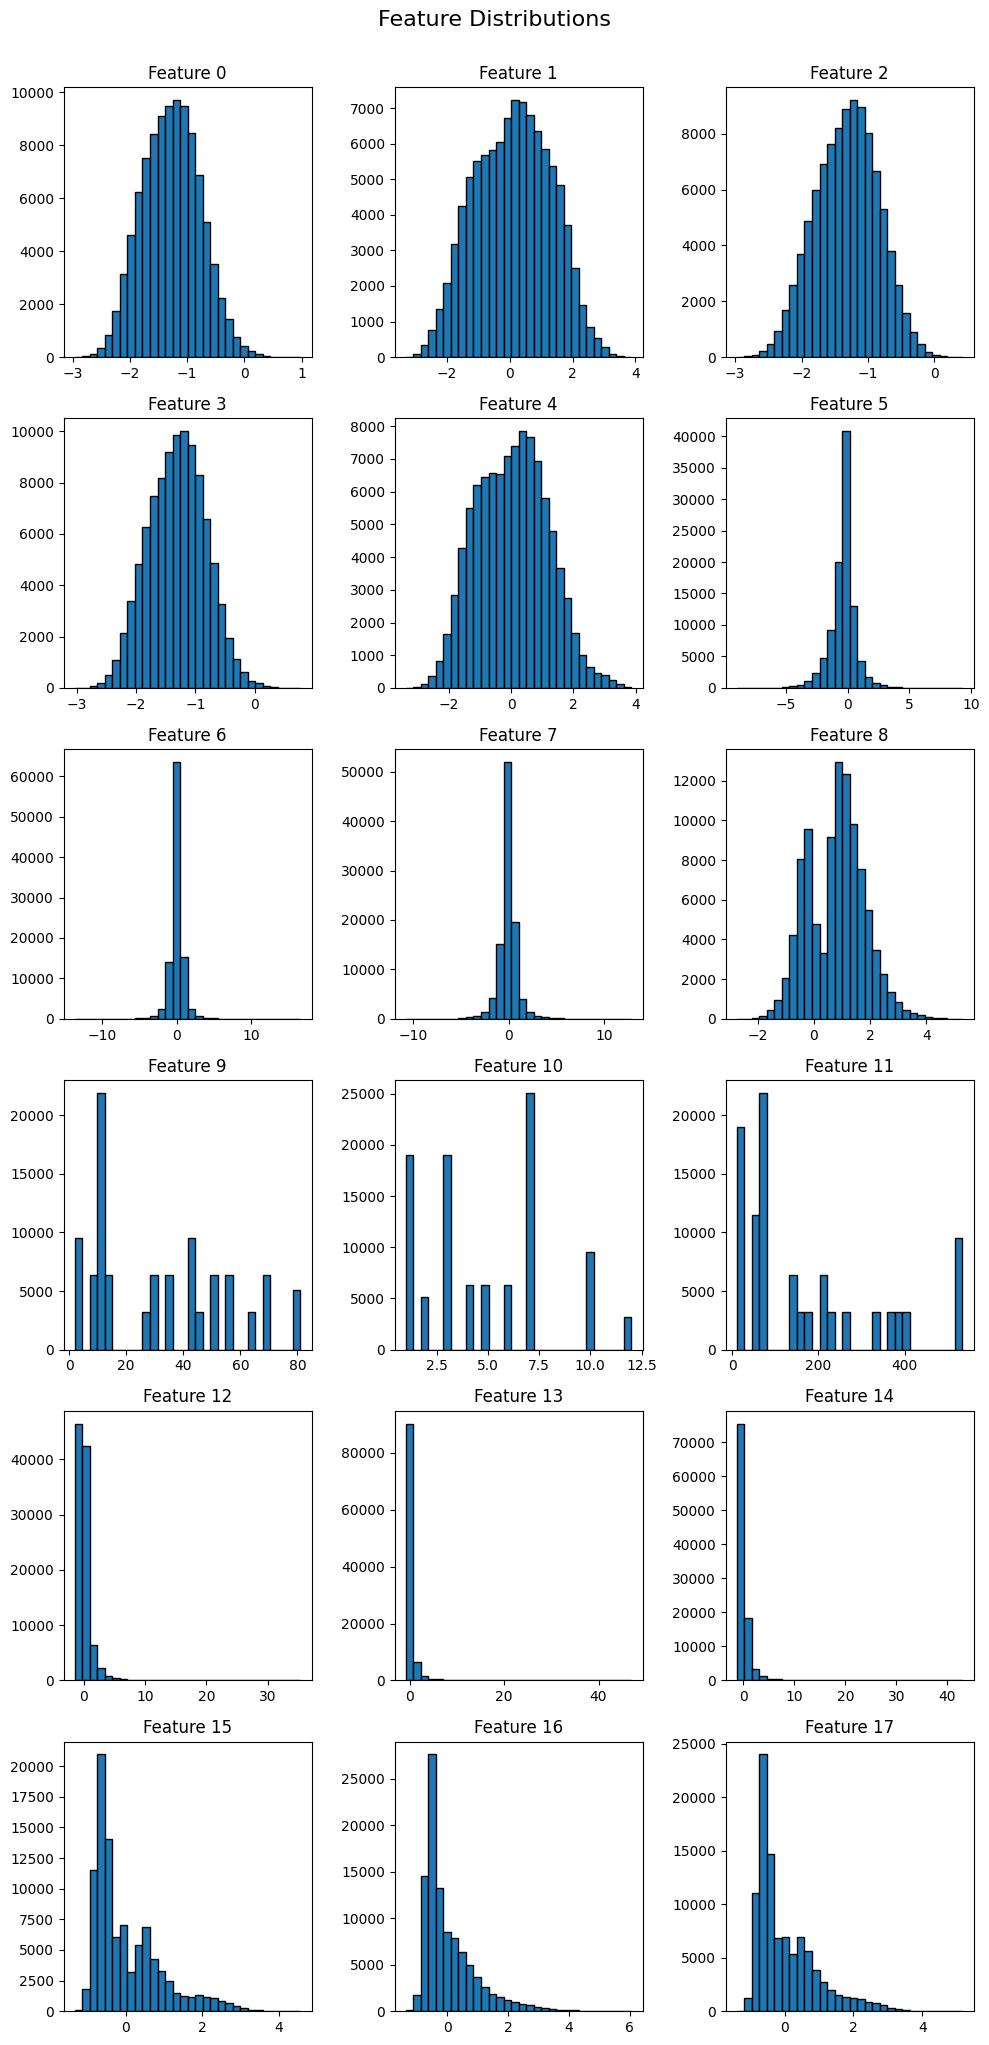

In [32]:
fig, axes = plt.subplots(nrows=6, ncols=3,figsize=(10, 20))
    
# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Plot histograms
for i in range(18):
   
    # Select the current subplot
    ax = axes_flat[i]
    
    # Plot histogram
    ax.hist(df[f'feature_{i:02}'][:100000],bins=30, edgecolor='black')
    ax.set_title(f'Feature {i}')

# Adjust layout and add overall title
plt.tight_layout()
fig.suptitle('Feature Distributions', fontsize=16, y=1.02)

In [ ]:
#sns.histplot(df["weight"])

In [4]:
def x_y_weight_split(dataframe):
    return dataframe.select(pl.col(r"^feat.+|date_id|time_id|weight$")), dataframe.select(pl.selectors.starts_with("resp")), dataframe.select(pl.col("weight"))

In [5]:
def bayes_model():
    x_train, y_train, _ = x_y_weight_split(df)
    x_train = x_train.fill_null(0)
    model = BayesianRidge()
    
    model.fit(x_train, y_train)
    return model

In [ ]:
# import pickle

# with open('bayes_model.pkl','wb') as f:
#     pickle.dump(model,f)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim, bias=False)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.SiLU()
        self.fc2 = nn.Linear(output_dim, output_dim, bias=False)
        self.bn2 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        identity = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class MLP(LightningModule):
    def __init__(self, input_dim, hidden_dim, blocks):
        super().__init__()
        self.save_hyperparameters()
        self.in_dim = input_dim
        self.first = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(0.3),
            nn.SiLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.3),
            nn.SiLU(),
            nn.BatchNorm1d(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.3),
            nn.SiLU(),
        )

        self.blocks = []
        for i in range(blocks):
            self.blocks.append(
                ResidualBlock(hidden_dim, hidden_dim)
            )
        self.blocks = nn.ModuleList(self.blocks)

        self.output = nn.Linear(hidden_dim, 9)
        self.tanh = nn.Tanh()
        
    
    def forward(self, x):
        first_out = self.first(x)
        x = first_out
        for block in self.blocks:
            x = block(x + first_out)
        x = self.tanh(self.output(x)) * 5
        return x
    
    def training_step(self, batch, batch_idx):
        x, y, w = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y).mean()
        self.log("train", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        return {'optimizer':optimizer}


In [ ]:
import gc
gc.collect()

In [ ]:
x_train = test_df.select(pl.col(r"^feat.+|date_id|time_id|weight$"))
x_train = x_train.fill_null(0).to_torch().float()
print(x_train.shape)
model = MLP(82, 150,12)
print(model(x_train).shape)
model

In [ ]:
lags_ : pl.DataFrame | None = None


# Replace this function with your inference code.
# You can return either a Pandas or Polars dataframe, though Polars is recommended.
# Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global lags_
    if lags is not None:
        lags_ = lags

    # Replace this section with your own predictions
    # predictions = test.select(
    #     'row_id',
    #     pl.lit(0.0).alias('responder_6'),
    # )

    x_test = test.select(pl.col(r"^feat.+|date_id|time_id|weight$"))
    y_out = model.predict(x_test.fill_null(0))
    predictions = test.select('row_id').with_columns(pl.Series('responder_6', y_out))

    if isinstance(predictions, pl.DataFrame):
        assert predictions.columns == ['row_id', 'responder_6']
    elif isinstance(predictions, pd.DataFrame):
        assert (predictions.columns == ['row_id', 'responder_6']).all()
    else:
        raise TypeError('The predict function must return a DataFrame')
    # Confirm has as many rows as the test data.
    assert len(predictions) == len(test)

    return predictions

In [ ]:
class LazyPolarsDataset(Dataset):
    def __init__(self, dataframe):
        self.x_train, self.y_train, self.weight = x_y_weight_split(dataframe)
        print(self.y_train.shape)
        self.x_train = self.x_train.fill_null(0).to_torch()
        self.y_train = self.y_train.to_torch()
        self.weight = self.weight.to_torch()


    def __len__(self):
        return self.x_train.shape[0]  # Number of rows in the DataFrame

    def __getitem__(self, idx):
        # Load a single row lazily
        x = self.x_train[idx]
        y = self.y_train[idx]
        weights = self.weight[idx]
        
        return x, y, weights

class PrintEpochCallback(L.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Epoch {trainer.current_epoch} completed.")

# Create Dataset
dataset = LazyPolarsDataset(df)
gc.collect()
# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=4096, prefetch_factor=4, shuffle=True, num_workers=4, pin_memory=True)

trainer = Trainer(max_epochs=30, callbacks= [PrintEpochCallback()])
trainer.fit(model, dataloader)
trainer.save_checkpoint("30.ckpt")


In [13]:
import pickle
with open('/kaggle/input/bayes/scikitlearn/default/1/bayes_model.pkl', 'rb') as f:
    model = pickle.load(f)
#model = MLP.load_from_checkpoint("/kaggle/input/ten/pytorch/default/1/ten.ckpt", input_dim=82, hidden_dim= 100,blocks=12)
valid_df = pl.scan_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet").head(200000).collect()
x_val, y_val, w_val = x_y_weight_split(valid_df)
x_val = x_val.fill_null(0)
y_val = y_val[:,6]
y_hat = model.predict(x_val)
r2_score(y_val, y_hat,sample_weight= w_val)

0.0019592999544774115